## 读取累计形变数据并绘图

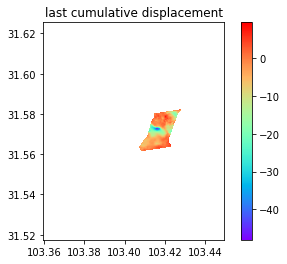

In [2]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import re
import os
%matplotlib inline
# %matplotlib notebook


def load_data(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    # Data array
    data = ds.GetRasterBand(band).ReadAsArray()
    # Map extent
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
              trans[3] + ysize*trans[5], trans[3]]
    ds = None
    return data, extent


def plot_data(data, extent, cmap, title):
    plt.figure()
    plt.imshow(data, extent=extent, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.show()


def get_date(disp_names):
    date = []
    for n in disp_names:
        date.append(re.findall(r'\d{8}', n)[0])
    return date


path = 'D:/GDAL/geocoded/'
os.chdir(path)
disp_names = sorted([i for i in os.listdir(path) if i.endswith('disp_geo')])

disp, extent = load_data(os.path.join(path, disp_names[1]))

lon = np.linspace(extent[0], extent[1], disp.shape[1])
lat = np.linspace(extent[3], extent[2], disp.shape[0])

lons, lats = np.meshgrid(lon, lat)

not_nan = (~np.isnan(disp))

lons = lons[not_nan].reshape((-1, 1))
lats = lats[not_nan].reshape((-1, 1))


# generate point ID
num = np.arange(0, lons.shape[0]).reshape((-1, 1))

cum_disp = np.concatenate([num, lons, lats], axis=1)


for disp_name in disp_names:
    disp_path = os.path.join(path, disp_name)
    disp, _ = load_data(disp_path)
    disp = disp[not_nan].reshape((-1, 1))
    cum_disp = np.concatenate([cum_disp, disp], axis=1)

# np.savetxt('cumulative_disp.txt', cum_disp, fmt='%4f')

last_cum_disp, extent = load_data(os.path.join(path, disp_names[-1]))
plot_data(data=last_cum_disp, extent=extent, cmap='rainbow',
          title='last cumulative displacement')

## 读取、保存平均速率数据并绘图

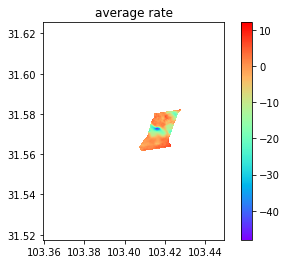

In [60]:
import random


def random_downsample(data, percent):
    point_num = data.shape[0]
    index = random.sample(range(point_num), int(point_num * percent))
    return data[index, :]


average_rate, extent = load_data(os.path.join(path, "SI_vel_geo"))
plot_data(data=average_rate, extent=extent,
          cmap='rainbow', title='average rate')
average_rate = average_rate[not_nan].reshape((-1, 1))
save_data = np.hstack((num, lons, lats, average_rate))

downsample_data = random_downsample(save_data, 0.5)

np.savetxt('average_rate_sample.txt', downsample_data, fmt='%4f')

## 绘制累计形变趋势图

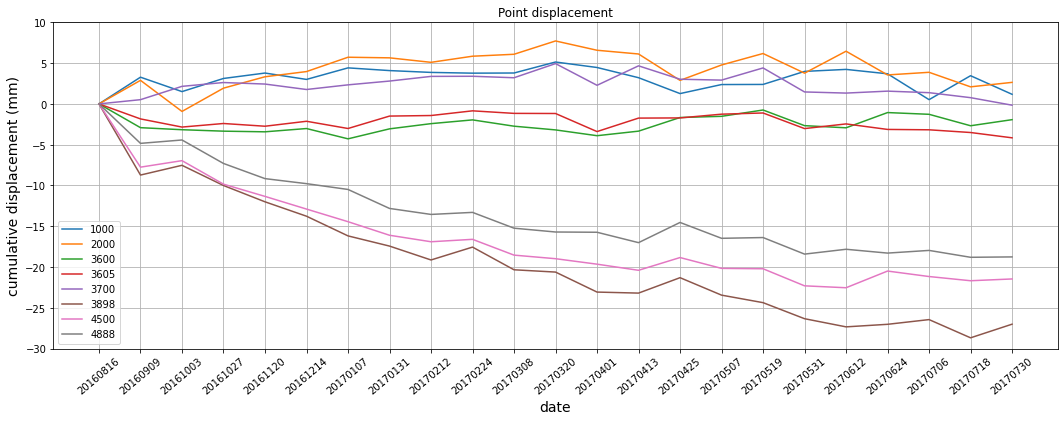

[1000.0, 103.44, 31.58, 0.0, 3.275, 1.508, 3.12, 3.783, 3.002, 4.418, 4.086, 3.861, 3.77, 3.79, 5.137, 4.465, 3.213, 1.265, 2.373, 2.387, 3.986, 4.23, 3.691, 0.521, 3.457, 1.176]

[2000.0, 103.44, 31.58, 0.0, 2.889, -0.924, 1.931, 3.328, 3.965, 5.723, 5.65, 5.098, 5.848, 6.086, 7.72, 6.58, 6.12, 2.885, 4.773, 6.18, 3.77, 6.46, 3.553, 3.875, 2.092, 2.64]

[3600.0, 103.44, 31.58, 0.0, -2.916, -3.166, -3.344, -3.424, -3.021, -4.285, -3.06, -2.422, -1.962, -2.734, -3.19, -3.9, -3.342, -1.669, -1.524, -0.7485, -2.668, -2.932, -1.063, -1.276, -2.68, -1.934]

[3604.0, 103.44, 31.58, 0.0, -1.841, -2.842, -2.404, -2.738, -2.13, -3.018, -1.494, -1.426, -0.851, -1.162, -1.178, -3.395, -1.741, -1.72, -1.261, -1.113, -3.027, -2.455, -3.13, -3.176, -3.51, -4.16]

[3700.0, 103.44, 31.58, 0.0, 0.5186, 2.152, 2.621, 2.434, 1.766, 2.336, 2.8, 3.373, 3.389, 3.207, 4.94, 2.281, 4.668, 3.023, 2.918, 4.41, 1.466, 1.326, 1.564, 1.376, 0.7646, -0.1578]

[3898.0, 103.44, 31.58, 0.0, -8.73, -7.53, -10.01, -12.0

In [16]:
def plot_point_disp(cum_disp, date, num_list):
    cum_disp = np.asarray(cum_disp, dtype=np.float16)
    point_disp = []
    for num in num_list:
        if num >= cum_disp.shape[0] or num < 0:
            print('Error: cannot find point {}\n'.format(num))
        else:
            line = cum_disp[num, :]
            plt.figure(figsize=(10, 5))
            point_disp.append(list(line))
            plt.plot(date, line[3:])
            plt.grid(True)
            plt.xticks(rotation=40)
            plt.ylim([-30, 10])
            plt.title('Point {}'.format(num))
            plt.xlabel('date', fontsize=14)
            plt.ylabel('cumulative displacement (mm)', fontsize=14)
            plt.savefig('cum_disp_{}.png'.format(num), dpi=300)
            plt.show()
    for i in point_disp:
        print('{}\n'.format(i))


def plot_point_disp_in_one(cum_disp, date, num_list):
    cum_disp = np.asarray(cum_disp, dtype=np.float16)
    point_disp = []
    plt.figure(figsize=(18, 6))
    for num in num_list:
        if num >= cum_disp.shape[0] or num < 0:
            print('Error: cannot find point {}\n'.format(num))
        else:
            line = cum_disp[num, :]
            point_disp.append(list(line))
            plt.plot(date, line[3:], label=str(num))
            plt.grid(True)
            plt.xticks(rotation=40)
            plt.ylim([-30, 10])
            plt.legend()
            plt.title('Point displacement')
            plt.xlabel('date', fontsize=14)
            plt.ylabel('cumulative displacement (mm)', fontsize=14)
    plt.savefig('cum_disp.png', dpi=300)
    plt.show()
    for i in point_disp:
        print('{}\n'.format(i))


date = get_date(disp_names)
num_list = sorted([4500, 4888, 3898, 3605, 3600, 1000, 2000, 3700])
plot_point_disp_in_one(cum_disp, date, num_list)